In [1]:
import os
import time
import pickle
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gaussian_preact
from gaussian_preact import ActivationFunction, ActivationFunctionPos, sampler_normal, build_sampler_weibull
from gaussian_preact.post_process import build_color, build_label, build_linestyle

torch.set_default_dtype(torch.float64)

plt.rcParams['text.usetex'] = 'True'
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]
path_objects = './objects/'

#lst_theta = [2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]    # extensive
lst_theta = [2.05, 2.50, 3.00, 4.00, 5.00, 7.00, 10.00]    # as in the paper
#lst_theta = [2.11]    # for testing

# Preliminary loads and plots

In [3]:
# Load the activation functions

dct_activations = {}

for theta in lst_theta:
    dct = torch.load(path_objects + 'ActFunction_theta-{:.2f}.pkl'.format(theta))
    dct_activations[('odd', theta)] = dct['activation']
    
    dct = torch.load(path_objects + 'ActFunctionPos_theta-{:.2f}.pkl'.format(theta))
    dct_activations[('pos', theta)] = dct['activation']

Text(0.5, 1.0, 'Positive activation functions')

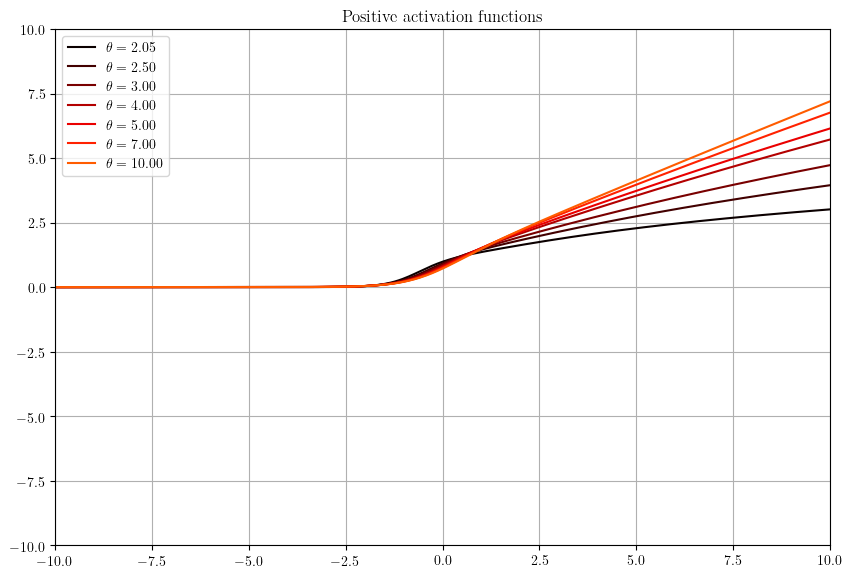

In [4]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]

tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations['pos', theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Positive activation functions')

Text(0.5, 1.0, 'Odd activation functions')

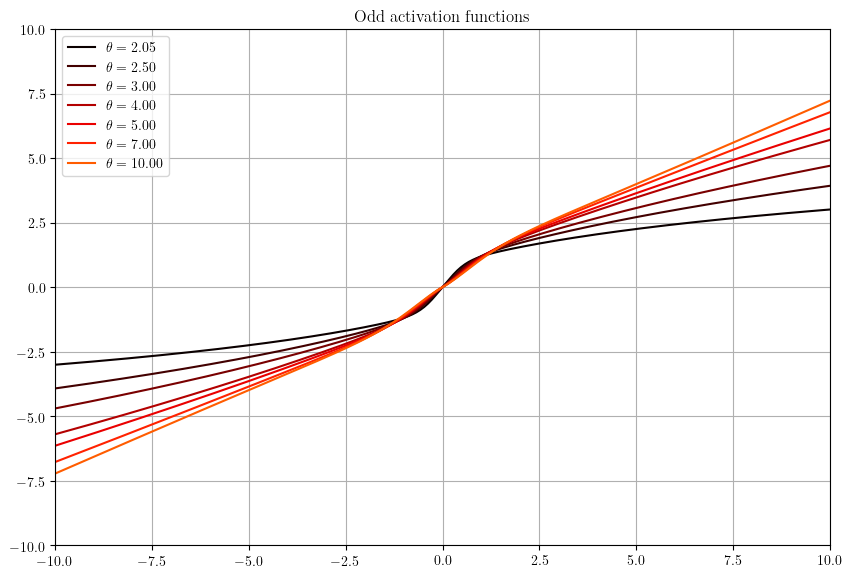

In [5]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]

tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations['odd', theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Odd activation functions')

# Test gaussianity

In [6]:
# Create Weibull initialization distributions
dct_samplers = {}
for theta in lst_theta:
    dct_samplers[theta] = build_sampler_weibull(theta)

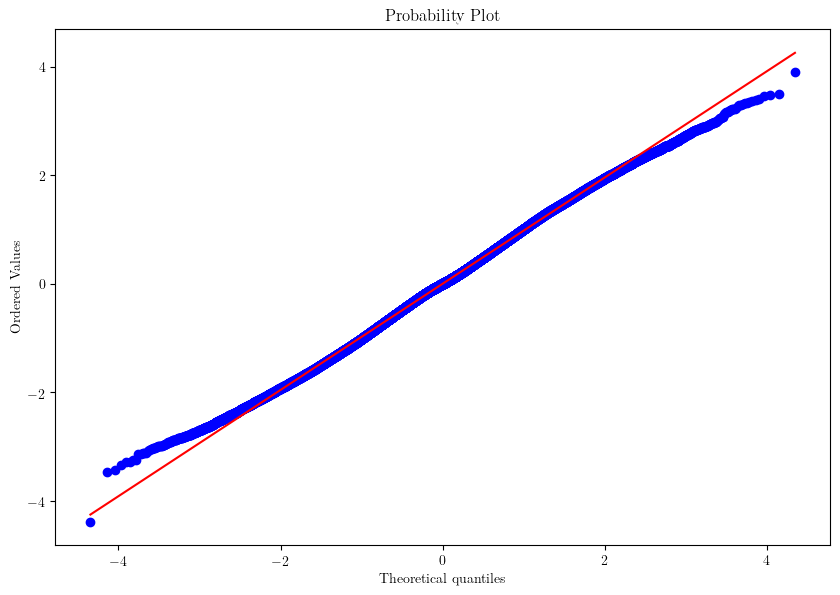

In [7]:
# Rapid test of gaussianity in a simple case: 
# Z = W * phi(X), where X is Gaussian

matplotlib.rcParams['figure.figsize'] = [10, 6.7]

n_samples = 100000
theta = 10

activation = dct_activations['odd', theta]
sampler_weibull = dct_samplers[theta]

z_in = torch.randn(n_samples)
x = activation(z_in)
w = sampler_weibull([n_samples])
z_out = x * w

_ = stats.probplot(z_out, dist = 'norm', plot = plt)

## KS-statistic for a 2-layer neural network

*Minimal model with dependence between pre-activations.*

TODO: documentation

In [8]:
def propagate(x, out_dim, sampler, sigma_w = 1.):
    w = sampler([x.size(0), out_dim, x.size(1)], device = x.device, dtype = x.dtype)
    w.mul_(sigma_w)
    ret = torch.bmm(w, x.unsqueeze(2)).squeeze() / np.sqrt(x.size(1))
    if ret.dim() == 1:
        ret = ret.unsqueeze(1)
    return ret

def full_propagation(x, lst_nl, sampler, activation, sigma_w = 1.):
    for i, nl in enumerate(lst_nl):
        if i == 0:
            sampler_ = sampler_normal
        else:
            sampler_ = sampler
        z = propagate(x, nl, sampler_, sigma_w)
        x = activation(z)
    
    return z[:,0]

In [9]:
sigma_w = 1.
n_samples = 200000

lst_nb_neur = list(range(1, 11))
in_dim = 1

In [10]:
dct_ks_1 = {}

for theta in lst_theta:
    for act_type in ['odd', 'pos']:
        dct_ks_1[(act_type, theta)] = []
        for n in lst_nb_neur:
            lst_nl = [1, n, 1]
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[theta], dct_activations[act_type, theta])
            dct_ks_1[act_type, theta].append(stats.kstest(z, stats.norm.cdf)[0])

In [11]:
dct_ks_2 = {}

for theta in lst_theta:
    for act_type in ['odd', 'pos']:
        dct_ks_2[(act_type, theta)] = []
        for n in lst_nb_neur:
            lst_nl = [n, 2, 1]
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[theta], dct_activations[act_type, theta])
            dct_ks_2[act_type, theta].append(stats.kstest(z, stats.norm.cdf)[0])

In [12]:
dct_ks_3 = {}

for theta in lst_theta:
    for act_type in ['odd', 'pos']:
        dct_ks_3[(act_type, theta)] = []
        for n in lst_nb_neur:
            lst_nl = [n, n, 1]
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[theta], dct_activations[act_type, theta])
            dct_ks_3[act_type, theta].append(stats.kstest(z, stats.norm.cdf)[0])

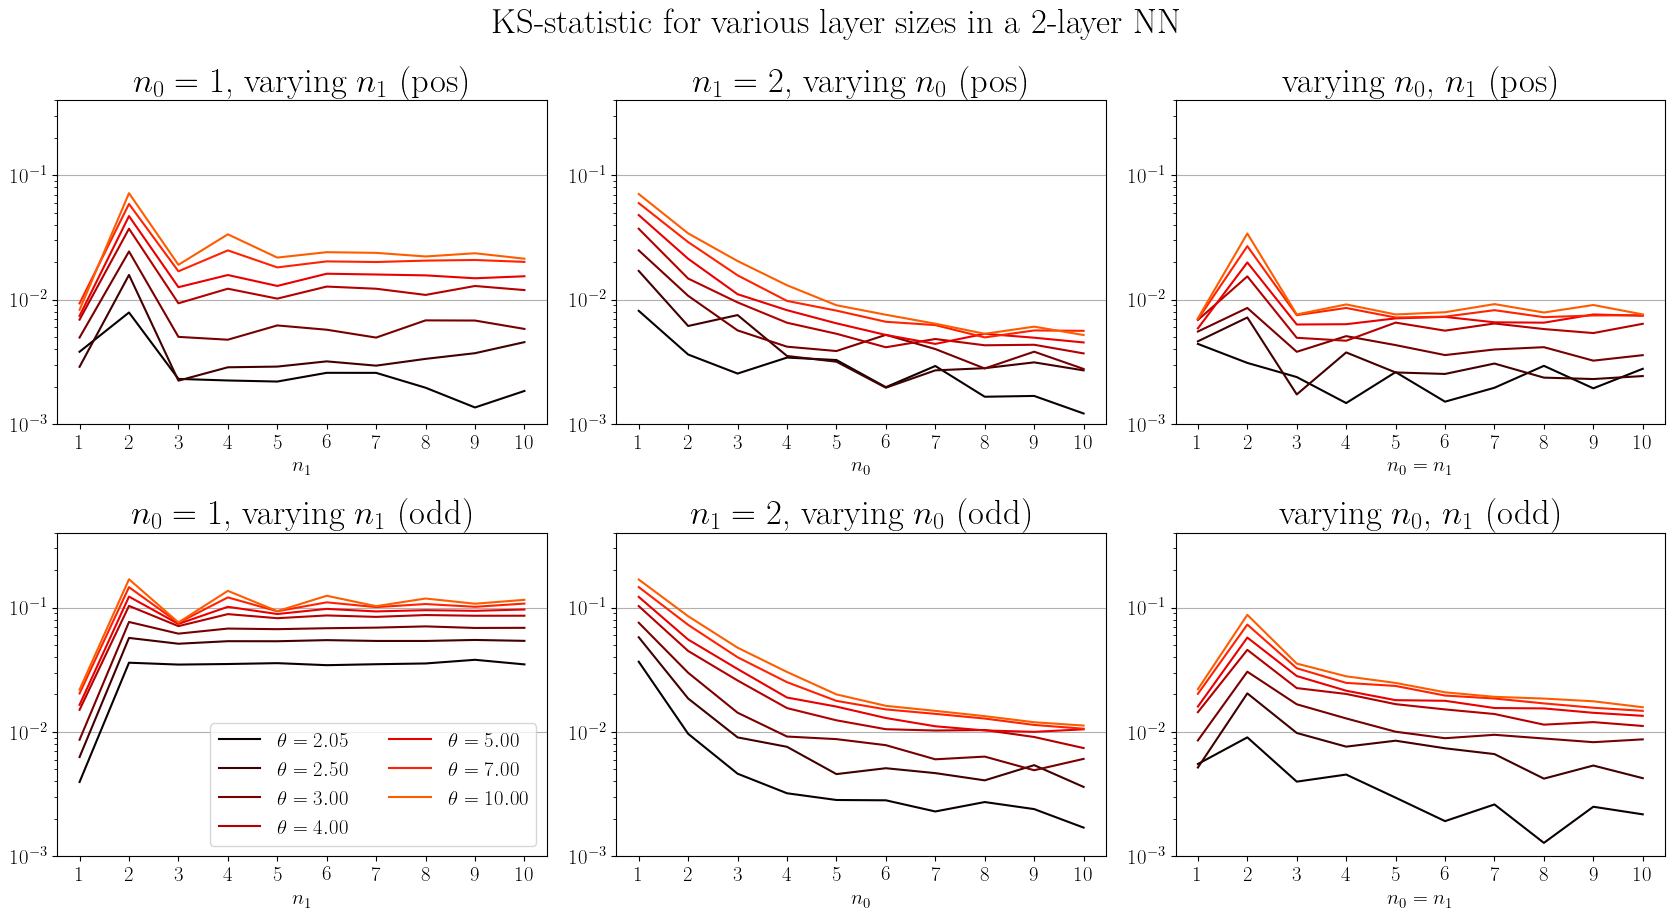

In [18]:
matplotlib.rcParams['figure.figsize'] = [17, 9.4]
matplotlib.rc('font', size = 15, weight = 'normal')
titlesize = 25

y_min, y_max = 1e-3, 4e-1

figure, axis = plt.subplots(2, 3)

for idx, act_type in enumerate(['pos', 'odd']):
    for theta in lst_theta:
        axis[idx,0].plot(list(range(1, 11)), dct_ks_1[act_type, theta], label = r'$\theta = {:.2f}$'.format(theta),
                c = build_color({'act_function': 'weibull', 'act_theta': theta}))
    if idx == 1:
        axis[idx,0].legend(ncol = 2)
    axis[idx,0].set_title('$n_0 = 1$, varying $n_1$ ({})'.format(act_type), fontsize = titlesize)
    
    axis[idx,0].set_yscale('log')
    axis[idx,0].set_ylim(y_min, y_max)
    
    axis[idx,0].set_xlabel('$n_1$')
    axis[idx,0].set_xticks(lst_nb_neur)
    
    # Varying Dmid, Din = 2
    for theta in lst_theta:
        axis[idx,1].plot(list(range(1, 11)), dct_ks_2[act_type, theta], label = r'$\theta = {:.2f}$'.format(theta),
                c = build_color({'act_function': 'weibull', 'act_theta': theta}))
    #axis[1].legend(ncol = 2)
    axis[idx,1].set_title('$n_1 = 2$, varying $n_0$ ({})'.format(act_type), fontsize = titlesize)
    
    axis[idx,1].set_yscale('log')
    axis[idx,1].set_ylim(y_min, y_max)
    
    axis[idx,1].set_xlabel('$n_0$')
    axis[idx,1].set_xticks(lst_nb_neur)
    
    # Varying Din, varying Dmid
    for theta in lst_theta:
        axis[idx,2].plot(list(range(1, 11)), dct_ks_3[act_type, theta], label = r'$\theta = {:.2f}$'.format(theta),
                c = build_color({'act_function': 'weibull', 'act_theta': theta}))
    #axis[2].legend(ncol = 2)
    axis[idx,2].set_title('varying $n_0$, $n_1$ ({})'.format(act_type), fontsize = titlesize)
    
    axis[idx,2].set_yscale('log')
    axis[idx,2].set_ylim(y_min, y_max)
    
    axis[idx,2].set_xticks(lst_nb_neur)
    axis[idx,2].set_xlabel('$n_0 = n_1$')

for i in range(2):
    for j in range(3):
        axis[i, j].grid(axis = 'y')

# Global title
plt.suptitle('KS-statistic for various layer sizes in a 2-layer NN', fontsize = titlesize)

plt.tight_layout()
plt.savefig('Init_KS_2layerNN_pos_odd.pdf')